## Target Shuffling Implementation

If a variable has a very large std. dev. --> lots of importance.
If a variable has a very small std. dev. (around 0) --> not much importance

Want to observe distribution of variables as well as accuracy of other models when shuffled

In [217]:
import pandas as pd
import numpy as np
from dfply import *
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
#import xgboost as xgb
import random

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last_expr"

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
cc = pd.read_csv("/Users/mfairb/Documents/ML Projects/Project - Anamoly Detection/creditcard.csv")

cc = cc >> drop('Time') >> select('Class', 'Amount', everything())

cc = cc.iloc[:,0:7]

X = cc >> drop('Class')
y = cc >> select('Class')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 273)

## There are problems with AUC (many ~ 0)

In [164]:
def target_shuffle(X_train, X_valid, y_train, y_valid, target, n):
    # 1) X: df of predictors
    # 2) y: response
    # 3) target: name of target variable (string)
    # 4) n: number of times to shuffle
        
    # Create empty data frame
    shuffle = pd.DataFrame()
    
    # Create n models and save coefficients
    for i in range(1, (n+1)):
        
            # Set seed
            random.seed(i)
            
            # Create shuffled version of y
            y_shuffled = y_train.sample(len(y_train), replace = False)
    
            # Create shuffled logistic, get predictions, and score
            temp_log = LogisticRegression().fit(X_train, y_shuffled.values.ravel())
            temp_preds = temp_log.predict_proba(X_valid)[:,1]
            temp_score = roc_auc_score(y_valid, temp_preds)
            
            # Score model

            # Get coefficients from temp_log
            shuffle = shuffle.append( list([np.append(temp_log.coef_[0], temp_score)]) )
            
            # Progress
            if i % 20 == 0:
                print(str(i) + " rounds completed")
    
    # Add column names to shuffle
    X_cols = list(X_train.columns)
    X_cols.append("AUC")
    shuffle.columns = X_cols
    
    return(shuffle)

###### Create model and then perform target shuffling

In [ ]:
# Logistic regression
log = LogisticRegression().fit(X_train, y_train.values.ravel())
log_preds = log.predict_proba(X_test)[:,1]
log_auc = roc_auc_score(y_test, log_preds)


shuffles = target_shuffle(X_train = X_train, 
                          y_train = y_train, 
                          X_valid = X_test, 
                          y_valid = y_test, 
                          target = 'Class', n = 100)

In [196]:
shuffles.head()

,Amount,V1,V2,V3,V4,V5,AUC
0,-0.000034,0.025221,0.004300,0.007803,-0.063428,-0.030677,0.066703
0,-0.000307,0.008480,-0.002189,0.000531,0.001570,0.029710,0.298475
0,0.000201,-0.000182,0.044762,0.040682,-0.023830,0.000106,0.125344
0,-0.000034,0.057103,0.061195,0.003473,-0.017321,0.007169,0.339613
0,0.000108,0.005997,0.011990,-0.014502,0.002429,0.006310,0.906563


###### Plot all histograms

In [219]:
###---To allow printing in for loop---###
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

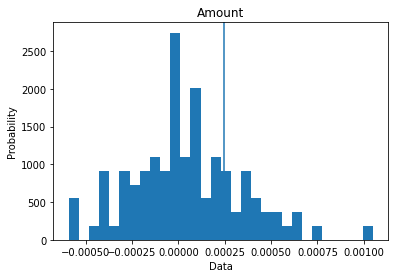

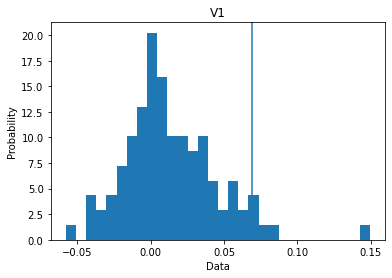

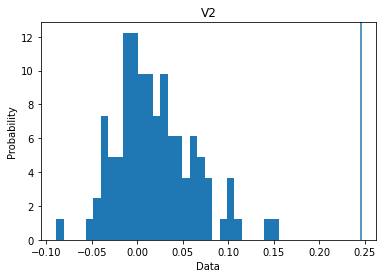

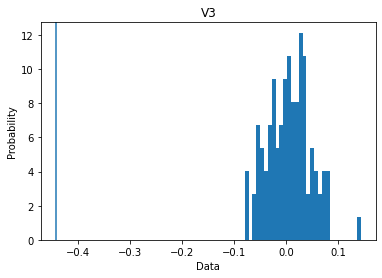

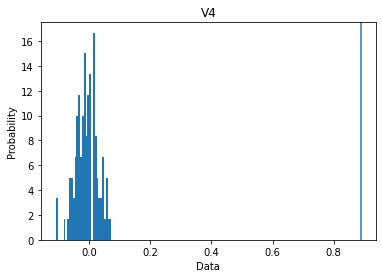

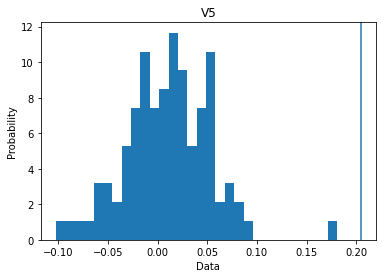

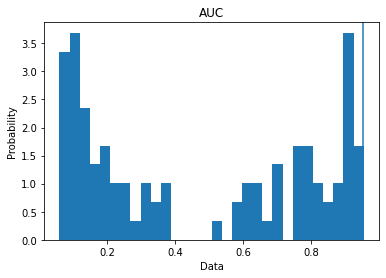

In [220]:
log_coef_2 = list( [np.append(log.coef_[0], log_auc)] )

for i in range(0, 7):
    plt.hist(shuffles.iloc[:,i], density=True, bins=30)  # `density=False` would make counts
    plt.axvline(x = log_coef_2[0][i])
    plt.title(shuffles.columns[i])
    plt.ylabel('Probability')
    plt.xlabel('Data')
    plt.show()